<a href="https://colab.research.google.com/github/balakrishnanvinchu/fair_accountable_machine_learning/blob/main/FATML_Sensitive_Data_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task 1: Exploratory Data Analysis

In [2]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.8 MB/s eta 0:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          690 non-null    int64  
 1   Age             690 non-null    float64
 2   Debt            690 non-null    float64
 3   Married         690 non-null    int64  
 4   BankCustomer    690 non-null    int64  
 5   Industry        690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    int64  
 9   Employed        690 non-null    int64  
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    int64  
 12  Citizen         690 non-null    object 
 13  ZipCode         690 non-null    int64  
 14  Income          690 non-null    int64  
 15  Approved        690 non-null    int64  
dtypes: float64(3), int64(10), object(3)
memory usage: 86.4+ KB
None
   Gender    Age

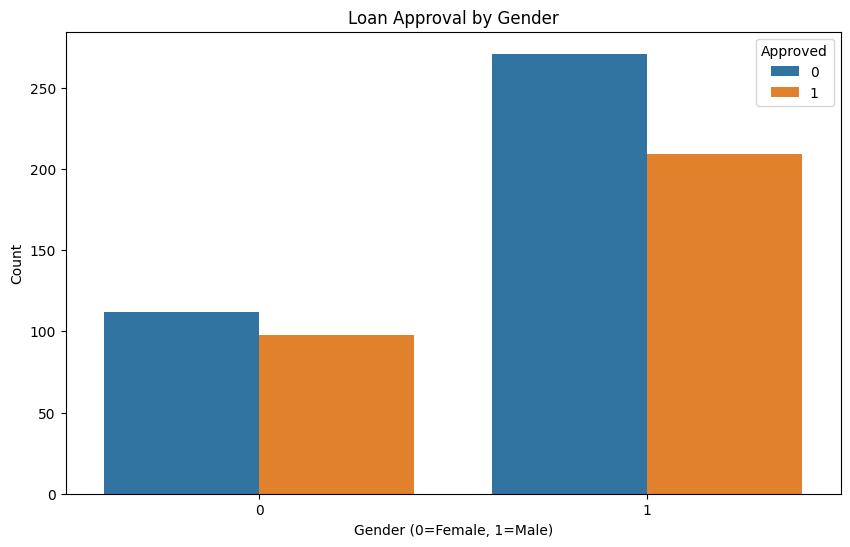


Approval Rates by Gender:
Gender
0    0.466667
1    0.435417
Name: Approved, dtype: float64


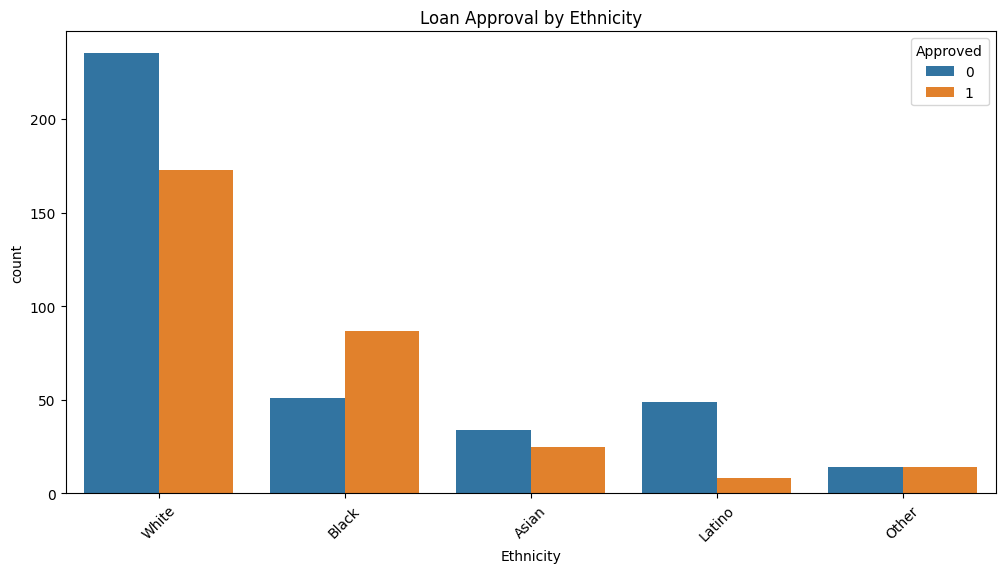

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    selection_rate
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.preprocessing import CorrelationRemover

# Load the dataset
df = pd.read_csv('clean_dataset.csv')

# Basic info
print(df.info())
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Visualize approval by gender
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='Approved', data=df)
plt.title('Loan Approval by Gender')
plt.xlabel('Gender (0=Female, 1=Male)')
plt.ylabel('Count')
plt.show()

# Calculate approval rates by gender
approval_rates = df.groupby('Gender')['Approved'].mean()
print("\nApproval Rates by Gender:")
print(approval_rates)

# Visualize other potential protected attributes
plt.figure(figsize=(12, 6))
sns.countplot(x='Ethnicity', hue='Approved', data=df)
plt.title('Loan Approval by Ethnicity')
plt.xticks(rotation=45)
plt.show()

## Task 2: Naïve Bayes with All Attributes (Baseline)

In [12]:
# Prepare data
X = df.drop('Approved', axis=1)
y = df['Approved']
sensitive_features = df['Gender']

# Encode categorical variables
categorical_cols = ['Married', 'BankCustomer', 'Industry', 'Ethnicity', 'PriorDefault',
                   'Employed', 'DriversLicense', 'Citizen', 'ZipCode']
label_encoders = {}
for col in categorical_cols:
    if col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

# Initialize model and metrics
model = GaussianNB()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results
accuracies_nb = []
dem_parity_diffs_nb = []
eq_odds_diffs_nb = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    sensitive_test = sensitive_features.iloc[test_idx]

    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
    eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)

    accuracies_nb.append(acc)
    dem_parity_diffs_nb.append(dp_diff)
    eq_odds_diffs_nb.append(eo_diff)

# Report results
print("\nTask 2 Results (With Sensitive Attribute):")
print(f"Average Accuracy: {np.mean(accuracies_nb):.4f}")
print(f"Average Demographic Parity Difference: {np.mean(dem_parity_diffs_nb):.4f}")
print(f"Average Equalized Odds Difference: {np.mean(eq_odds_diffs_nb):.4f}")


Task 2 Results (With Sensitive Attribute):
Average Accuracy: 0.7884
Average Demographic Parity Difference: 0.0515
Average Equalized Odds Difference: 0.0953


## Task 3: Naïve Bayes Without Sensitive Attribute

In [14]:
# Remove gender from features
X_no_gender = X.drop('Gender', axis=1)

# Store results
accuracies_nb_wo_sensitive = []
dem_parity_diffs_nb_wo_sensitive = []
eq_odds_diffs_nb_wo_sensitive = []

for train_idx, test_idx in kf.split(X_no_gender):
    X_train, X_test = X_no_gender.iloc[train_idx], X_no_gender.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    sensitive_test = sensitive_features.iloc[test_idx]

    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
    eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)

    accuracies_nb_wo_sensitive.append(acc)
    dem_parity_diffs_nb_wo_sensitive.append(dp_diff)
    eq_odds_diffs_nb_wo_sensitive.append(eo_diff)

# Report results
print("\nTask 3 Results (Without Sensitive Attribute):")
print(f"Average Accuracy: {np.mean(accuracies_nb_wo_sensitive):.4f}")
print(f"Average Demographic Parity Difference: {np.mean(dem_parity_diffs_nb_wo_sensitive):.4f}")
print(f"Average Equalized Odds Difference: {np.mean(eq_odds_diffs_nb_wo_sensitive):.4f}")


Task 3 Results (Without Sensitive Attribute):
Average Accuracy: 0.7870
Average Demographic Parity Difference: 0.0585
Average Equalized Odds Difference: 0.1064


## Task 4: Reweighting Preprocessing

In [15]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

# Prepare data with gender
X_with_gender = X.copy()

# Store results
accuracies_nb_weighted = []
dem_parity_diffs_nb_weighted = []
eq_odds_diffs_nb_weighted = []

for train_idx, test_idx in kf.split(X_with_gender):
    X_train, X_test = X_with_gender.iloc[train_idx], X_with_gender.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    sensitive_train = sensitive_features.iloc[train_idx]
    sensitive_test = sensitive_features.iloc[test_idx]

    # Apply reweighting
    constraint = DemographicParity()
    mitigator = ExponentiatedGradient(
        estimator=GaussianNB(),
        constraints=constraint
    )

    mitigator.fit(X_train, y_train, sensitive_features=sensitive_train)
    y_pred = mitigator.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
    eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)

    accuracies_nb_weighted.append(acc)
    dem_parity_diffs_nb_weighted.append(dp_diff)
    eq_odds_diffs_nb_weighted.append(eo_diff)

# Report results
print("\nTask 4 Results (With Reweighting):")
print(f"Average Accuracy: {np.mean(accuracies_nb_weighted):.4f}")
print(f"Average Demographic Parity Difference: {np.mean(dem_parity_diffs_nb_weighted):.4f}")
print(f"Average Equalized Odds Difference: {np.mean(eq_odds_diffs_nb_weighted):.4f}")


Task 4 Results (With Reweighting):
Average Accuracy: 0.7841
Average Demographic Parity Difference: 0.0675
Average Equalized Odds Difference: 0.0933


## Task 5: Universal Sampling Preprocessing

In [16]:
from fairlearn.preprocessing import CorrelationRemover

# Store results
accuracies_univ_sampling = []
dem_parity_diffs_univ_sampling = []
eq_odds_diffs_univ_sampling = []

for train_idx, test_idx in kf.split(X_with_gender):
    X_train, X_test = X_with_gender.iloc[train_idx], X_with_gender.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    sensitive_train = sensitive_features.iloc[train_idx]
    sensitive_test = sensitive_features.iloc[test_idx]

    # Apply universal sampling (correlation removal)
    cr = CorrelationRemover(sensitive_feature_ids=['Gender'])
    X_train_fair = cr.fit_transform(X_train)
    X_test_fair = cr.transform(X_test)

    # Train and predict
    model.fit(X_train_fair, y_train)
    y_pred = model.predict(X_test_fair)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
    eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)

    accuracies_univ_sampling.append(acc)
    dem_parity_diffs_univ_sampling.append(dp_diff)
    eq_odds_diffs_univ_sampling.append(eo_diff)

# Report results
print("\nTask 5 Results (With Universal Sampling):")
print(f"Average Accuracy: {np.mean(accuracies_univ_sampling):.4f}")
print(f"Average Demographic Parity Difference: {np.mean(dem_parity_diffs_univ_sampling):.4f}")
print(f"Average Equalized Odds Difference: {np.mean(eq_odds_diffs_univ_sampling):.4f}")


Task 5 Results (With Universal Sampling):
Average Accuracy: 0.7884
Average Demographic Parity Difference: 0.0673
Average Equalized Odds Difference: 0.1023


## Task 6: Preferential Sampling Preprocessing

In [17]:
from fairlearn.postprocessing import ThresholdOptimizer

# Store results
accuracies_pref_sampling = []
dem_parity_diffs_pref_sampling = []
eq_odds_diffs_pref_sampling = []

for train_idx, test_idx in kf.split(X_with_gender):
    X_train, X_test = X_with_gender.iloc[train_idx], X_with_gender.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    sensitive_train = sensitive_features.iloc[train_idx]
    sensitive_test = sensitive_features.iloc[test_idx]

    # Apply preferential sampling (threshold optimization)
    postprocess_est = ThresholdOptimizer(
        estimator=GaussianNB(),
        constraints="demographic_parity"
    )

    postprocess_est.fit(X_train, y_train, sensitive_features=sensitive_train)
    y_pred = postprocess_est.predict(X_test, sensitive_features=sensitive_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
    eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)

    accuracies_pref_sampling.append(acc)
    dem_parity_diffs_pref_sampling.append(dp_diff)
    eq_odds_diffs_pref_sampling.append(eo_diff)

# Report results
print("\nTask 6 Results (With Preferential Sampling):")
print(f"Average Accuracy: {np.mean(accuracies_pref_sampling):.4f}")
print(f"Average Demographic Parity Difference: {np.mean(dem_parity_diffs_pref_sampling):.4f}")
print(f"Average Equalized Odds Difference: {np.mean(eq_odds_diffs_pref_sampling):.4f}")


Task 6 Results (With Preferential Sampling):
Average Accuracy: 0.8275
Average Demographic Parity Difference: 0.0351
Average Equalized Odds Difference: 0.0631


## Comparison


Comparison of All Approaches:
                                 Accuracy   DP Diff   EO Diff
Task 2 (With Sensitive Attr)     0.788406  0.051537  0.095274
Task 3 (Without Sensitive Attr)  0.786957  0.058520  0.106385
Task 4 (Reweighting)             0.784058  0.067544  0.093311
Task 5 (Universal Sampling)      0.788406  0.067250  0.102344
Task 6 (Pref. Sampling)          0.827536  0.035107  0.063136


<Figure size 1200x600 with 0 Axes>

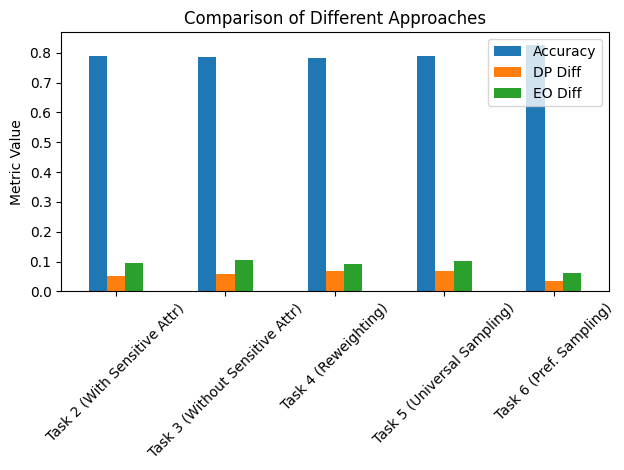

In [19]:
results = {
    "Task 2 (With Sensitive Attr)": {
        "Accuracy": np.mean(accuracies_nb),
        "DP Diff": np.mean(dem_parity_diffs_nb),
        "EO Diff": np.mean(eq_odds_diffs_nb)
    },
    "Task 3 (Without Sensitive Attr)": {
        "Accuracy": np.mean(accuracies_nb_wo_sensitive),
        "DP Diff": np.mean(dem_parity_diffs_nb_wo_sensitive),
        "EO Diff": np.mean(eq_odds_diffs_nb_wo_sensitive)
    },
    "Task 4 (Reweighting)": {
        "Accuracy": np.mean(accuracies_nb_weighted),
        "DP Diff": np.mean(dem_parity_diffs_nb_weighted),
        "EO Diff": np.mean(eq_odds_diffs_nb_weighted)
    },
    "Task 5 (Universal Sampling)": {
        "Accuracy": np.mean(accuracies_univ_sampling),
        "DP Diff": np.mean(dem_parity_diffs_univ_sampling),
        "EO Diff": np.mean(eq_odds_diffs_univ_sampling)
    },
    "Task 6 (Pref. Sampling)": {
        "Accuracy": np.mean(accuracies_pref_sampling),
        "DP Diff": np.mean(dem_parity_diffs_pref_sampling),
        "EO Diff": np.mean(eq_odds_diffs_pref_sampling)
    }
}

# Create comparison table
comparison_df = pd.DataFrame(results).T
print("\nComparison of All Approaches:")
print(comparison_df)

# Plot comparison
plt.figure(figsize=(12, 6))
comparison_df.plot(kind='bar', y=['Accuracy', 'DP Diff', 'EO Diff'])
plt.title('Comparison of Different Approaches')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()